In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.2 MB/s eta 0:00:00


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import re
import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import copy
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from torch import nn
import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creazione Dataset
Caricamento dei dati di train per creare il dataset "Data" contenenete le colonne "text" e "labels"

In [26]:
#Creazione dataset, la prima colonna è il testo intero del tweet
#La seconda colonna sono le etichette
#0 = Rabbia
#1 = Gioia
#2 = Ottimismo
#3 = Tristezza

datas = "/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_text.txt"
with open(datas, 'r', encoding='utf-8') as f:
    tweets = f.readlines()

tweets = [tweet.strip() for tweet in tweets]

data = pd.DataFrame(tweets, columns=['text'])

labels ="/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_labels.txt"
with open(labels, 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]

data.insert(1, "label", labels2)
texts = pd.DataFrame(data, columns=["text"])
data.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3257 non-null   object
 1   label   3257 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


Analizziamo l'equilibrio dei dati

samples -> 3257
categories -> {0, 1, 2, 3}[4]
label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64


<Axes: xlabel='label'>

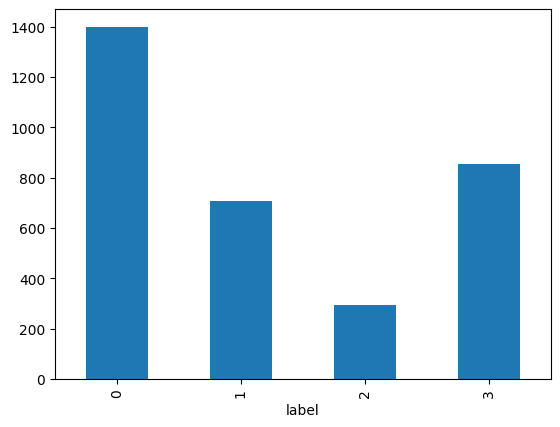

In [28]:
print('samples -> '+str(len(data)))
labels = set(data['label'])
numLabels = len(labels)
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(data['label'].value_counts())
data.groupby(['label']).size().plot.bar()

# Preprocessing dei dati

Eseguiamo un Preprocessing, facendo features extraction.
Troviamo le Features:
- emoji count
- Aggettivi
- Verbi
- Sostantivi
- Avverbi
- Word Count
- Important Word Count
- Lunghezza del testo

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Tokenized: ['This', 'is', 'a', 'test', 'sentence', '.']
POS Tags: [('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('test', 'NN'), ('sentence', 'NN'), ('.', '.')]
Index(['text', 'label', 'emoji_count', 'pos_counts', 'JJ', 'VB', 'NN', 'RB'], dtype='object')
             JJ        VB        NN        RB     label
JJ     1.000000  0.125986  0.107958  0.113710  0.020748
VB     0.125986  1.000000  0.113673  0.300368 -0.045532
NN     0.107958  0.113673  1.000000 -0.048270 -0.089795
RB     0.113710  0.300368 -0.048270  1.000000  0.044991
label  0.020748 -0.045532 -0.089795  0.044991  1.000000


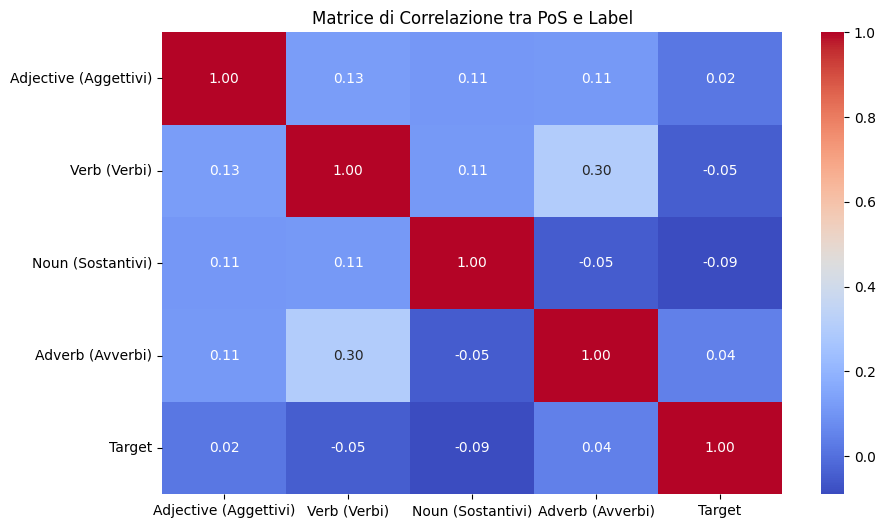

In [29]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

data['emoji_count'] = data['text'].apply(lambda text: sum(char in emoji.EMOJI_DATA.keys() for char in text))

data['text'] = data['text'].apply(lambda text: emoji.demojize(text))

text = "This is a test sentence."
tokens = word_tokenize(text)
print("Tokenized:", tokens)

tags = pos_tag(tokens)
print("POS Tags:", tags)

def extract_pos_counts(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    pos_counts = {
        'JJ': 0,
        'VB': 0,
        'NN': 0,
        'RB': 0
    }
    for _, tag in tagged:
        if tag.startswith('JJ'):
            pos_counts['JJ'] += 1
        elif tag.startswith('VB'):
            pos_counts['VB'] += 1
        elif tag.startswith('NN'):
            pos_counts['NN'] += 1
        elif tag.startswith('RB'):
            pos_counts['RB'] += 1
    return pos_counts

data['pos_counts'] = data['text'].apply(extract_pos_counts)
df_pos = data['pos_counts'].apply(pd.Series)
data = pd.concat([data, df_pos], axis=1)

print(data.columns)

correlation_matrix = data[['JJ', 'VB', 'NN', 'RB', 'label']].corr()
print(correlation_matrix)

df_pos = data['pos_counts'].apply(pd.Series)

df = data.drop(columns=['JJ', 'VB', 'NN', 'RB'], errors='ignore')
df = pd.concat([data, df_pos], axis=1)

correlation_matrix = data[['JJ', 'VB', 'NN', 'RB', 'label']].corr()

pos_labels = {
    'JJ': 'Adjective (Aggettivi)',
    'VB': 'Verb (Verbi)',
    'NN': 'Noun (Sostantivi)',
    'RB': 'Adverb (Avverbi)',
    'label': 'Target'
}

correlation_matrix.rename(columns=pos_labels, index=pos_labels, inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice di Correlazione tra PoS e Label")
plt.show()



In [30]:
data['word_count'] = data['text'].apply(lambda x: len(x.split()))
data['important_word_count'] = data['JJ'] + data['NN'] + data['RB'] + data['VB']
data['text_length'] = data['text'].apply(len)
data

,text,label,emoji_count,pos_counts,JJ,VB,NN,RB,word_count,important_word_count,text_length
0,“Worry is a down payment on a problem you may ...,2,0,"{'JJ': 1, 'VB': 2, 'NN': 9, 'RB': 1}",1,2,9,1,17,13,104
1,My roommate: it's okay that we can't spell bec...,0,0,"{'JJ': 3, 'VB': 3, 'NN': 2, 'RB': 1}",3,3,2,1,14,9,98
2,No but that's so cute. Atsu was probably shy a...,1,0,"{'JJ': 3, 'VB': 3, 'NN': 3, 'RB': 2}",3,3,3,2,18,11,94
3,Rooneys fucking untouchable isn't he? Been fuc...,0,0,"{'JJ': 4, 'VB': 5, 'NN': 4, 'RB': 2}",4,5,4,2,13,15,102
4,it's pretty depressing when u hit pan on ur fa...,3,0,"{'JJ': 4, 'VB': 2, 'NN': 3, 'RB': 0}",4,2,3,0,11,9,65
...,...,...,...,...,...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,0,"{'JJ': 0, 'VB': 6, 'NN': 7, 'RB': 0}",0,6,7,0,27,13,136
3253,The @user are in contention and hosting @user ...,3,0,"{'JJ': 3, 'VB': 3, 'NN': 6, 'RB': 0}",3,3,6,0,14,12,77
3254,@user @user @user @user @user as a fellow UP g...,0,0,"{'JJ': 1, 'VB': 1, 'NN': 15, 'RB': 0}",1,1,15,0,18,17,95
3255,You have a #problem? Yes! Can you do #somethin...,0,0,"{'JJ': 0, 'VB': 2, 'NN': 3, 'RB': 0}",0,2,3,0,14,5,70


In [31]:
data['hashtags'] = data['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))

hashtags_exploded = data.explode('hashtags').dropna(subset=['hashtags'])

hashtag_counts = (
    hashtags_exploded.groupby(['hashtags', 'label'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'count_anger', 1: 'count_joy', 2: 'count_opt', 3: 'count_sad'})
)

hashtag_counts['count_total'] = hashtag_counts['count_anger'] + hashtag_counts['count_joy'] + hashtag_counts['count_opt'] + hashtag_counts['count_sad']
hashtag_counts['anger_ratio'] = hashtag_counts['count_anger'] / hashtag_counts['count_total']
hashtag_counts['joy_ratio'] = hashtag_counts['count_joy'] / hashtag_counts['count_total']
hashtag_counts['opt_ratio'] = hashtag_counts['count_opt'] / hashtag_counts['count_total']
hashtag_counts['sad_ratio'] = hashtag_counts['count_sad'] / hashtag_counts['count_total']

hashtag_counts = hashtag_counts.sort_values(by='count_total', ascending=False)

print(hashtag_counts)

significant_hashtags = hashtag_counts[hashtag_counts['count_total'] > 3]
print(significant_hashtags)

label        count_anger  count_joy  count_opt  count_sad  count_total  \
hashtags                                                                 
#sad                   1          0          0         49           50   
#depression            0          0          1         41           42   
#sadness               0          0          0         38           38   
#terrorism            22          0          7          5           34   
#fear                  8          1         14         10           33   
...                  ...        ...        ...        ...          ...   
#アニメ                   1          0          0          0            1   
#1                     1          0          0          0            1   
#10golds24             0          0          1          0            1   
#12years               0          1          0          0            1   
#2                     0          0          1          0            1   

label        anger_ratio  joy_ratio  

Eseguiamo anche una Features Extraction analizzando gli hashtag e estraendo
- has_anger_hashtag
- has_joy_hashtag
- has_opt_hashtag
- has_sad_hashtag

In [32]:
data['has_anger_hashtag'] = data['hashtags'].apply(
    lambda x: 1 if any(ht in significant_hashtags[significant_hashtags['anger_ratio'] > 0.6].index for ht in x) else 0
)
data['has_joy_hashtag'] = data['hashtags'].apply(
    lambda x: 1 if any(ht in significant_hashtags[significant_hashtags['joy_ratio'] < 0.4].index for ht in x) else 0
)
data['has_opt_hashtag'] = data['hashtags'].apply(
    lambda x: 1 if any(ht in significant_hashtags[significant_hashtags['opt_ratio'] > 0.6].index for ht in x) else 0
)
data['has_sad_hashtag'] = data['hashtags'].apply(
    lambda x: 1 if any(ht in significant_hashtags[significant_hashtags['sad_ratio'] < 0.4].index for ht in x) else 0
)

In [33]:
data

,text,label,emoji_count,pos_counts,JJ,VB,NN,RB,word_count,important_word_count,text_length,hashtags,has_anger_hashtag,has_joy_hashtag,has_opt_hashtag,has_sad_hashtag
0,“Worry is a down payment on a problem you may ...,2,0,"{'JJ': 1, 'VB': 2, 'NN': 9, 'RB': 1}",1,2,9,1,17,13,104,"[#motivation, #leadership, #worry]",0,1,1,1
1,My roommate: it's okay that we can't spell bec...,0,0,"{'JJ': 3, 'VB': 3, 'NN': 2, 'RB': 1}",3,3,2,1,14,9,98,"[#terrible, #firstworldprobs]",1,1,0,1
2,No but that's so cute. Atsu was probably shy a...,1,0,"{'JJ': 3, 'VB': 3, 'NN': 3, 'RB': 2}",3,3,3,2,18,11,94,[],0,0,0,0
3,Rooneys fucking untouchable isn't he? Been fuc...,0,0,"{'JJ': 4, 'VB': 5, 'NN': 4, 'RB': 2}",4,5,4,2,13,15,102,[],0,0,0,0
4,it's pretty depressing when u hit pan on ur fa...,3,0,"{'JJ': 4, 'VB': 2, 'NN': 3, 'RB': 0}",4,2,3,0,11,9,65,[],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,0,"{'JJ': 0, 'VB': 6, 'NN': 7, 'RB': 0}",0,6,7,0,27,13,136,[],0,0,0,0
3253,The @user are in contention and hosting @user ...,3,0,"{'JJ': 3, 'VB': 3, 'NN': 6, 'RB': 0}",3,3,6,0,14,12,77,[#sad],0,1,0,0
3254,@user @user @user @user @user as a fellow UP g...,0,0,"{'JJ': 1, 'VB': 1, 'NN': 15, 'RB': 0}",1,1,15,0,18,17,95,[],0,0,0,0
3255,You have a #problem? Yes! Can you do #somethin...,0,0,"{'JJ': 0, 'VB': 2, 'NN': 3, 'RB': 0}",0,2,3,0,14,5,70,"[#problem, #something]",0,0,0,0


Calcoliamo la matrice di correlazione delle Features numeriche

In [34]:
labels = data["label"]
data2 = data.drop("text", axis=1)
data2.drop("pos_counts", axis=1, inplace=True)
data2.drop("hashtags", axis=1, inplace=True)

<Axes: >

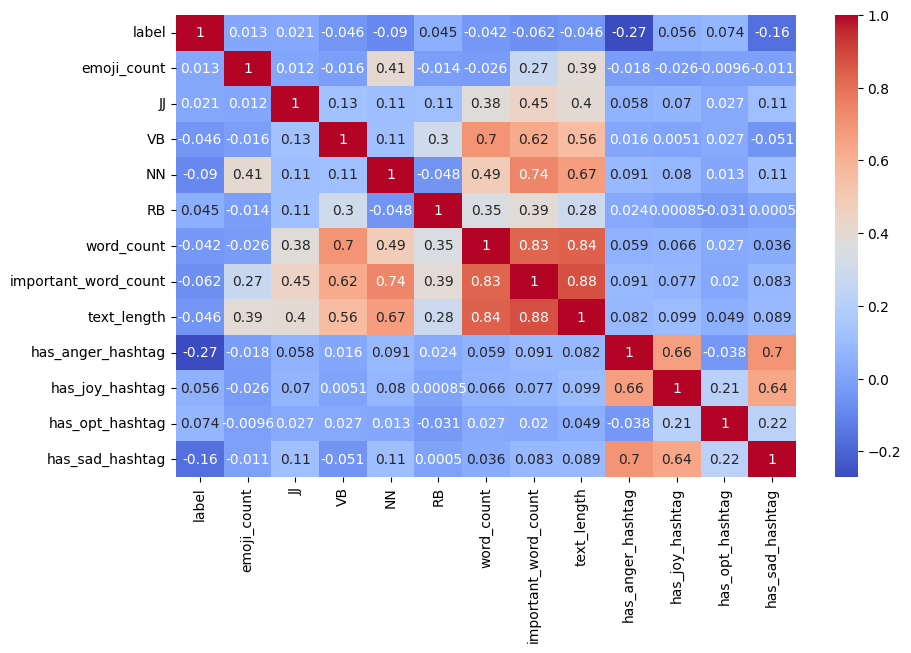

In [35]:
plt.figure(figsize=(10, 6))
sns.heatmap(data2.corr(), cmap="coolwarm", annot=True)

# Features Selection
Eseguiamo una Features Selection utilizzando RandomForestClassifier come modello e otteniamo le seguenti Features:
- VB
- NN
- word_count
- important_word_count
- text_length

In [36]:
data2.drop("label", axis=1, inplace=True)
featureSel = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1), max_features=5)
data3 = featureSel.fit_transform(data2, labels)
print(f"Features tenute: {featureSel.get_feature_names_out()}")

Features tenute: ['VB' 'NN' 'word_count' 'important_word_count' 'text_length']


In [37]:
data3 = pd.DataFrame(data3, columns=["VB", "NN", "word_count", "important_word_count", "text_length"])
data3.insert(0, "text", data["text"])
data3.insert(6, "label",labels)
data3

,text,VB,NN,word_count,important_word_count,text_length,label
0,“Worry is a down payment on a problem you may ...,2,9,17,13,104,2
1,My roommate: it's okay that we can't spell bec...,3,2,14,9,98,0
2,No but that's so cute. Atsu was probably shy a...,3,3,18,11,94,1
3,Rooneys fucking untouchable isn't he? Been fuc...,5,4,13,15,102,0
4,it's pretty depressing when u hit pan on ur fa...,2,3,11,9,65,3
...,...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,6,7,27,13,136,3
3253,The @user are in contention and hosting @user ...,3,6,14,12,77,3
3254,@user @user @user @user @user as a fellow UP g...,1,15,18,17,95,0
3255,You have a #problem? Yes! Can you do #somethin...,2,3,14,5,70,0


# Caricamento Dataset Validation
Eseguiamo le stesse procedure di Features Extraction sul validation solo per quelle selezionate in fase di Features Selection


In [38]:
x_train = data3['text']
y_train = data3['label']
VB = data3['VB']
NN = data3['NN']
word_count = data3['word_count']
important_word_count = data3['important_word_count']
text_length = data3['text_length']

with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/val_text.txt", 'r', encoding='utf-8') as f:
    tweets = f.readlines()

tweets = [tweet.strip() for tweet in tweets]
val_text_df = pd.DataFrame(tweets, columns=['text'])

with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/val_labels.txt", 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]
val_text_df['pos_counts'] = val_text_df['text'].apply(extract_pos_counts)
df_pos = val_text_df['pos_counts'].apply(pd.Series)
val_text_df = pd.concat([val_text_df, df_pos], axis=1)
val_text_df['word_count'] = val_text_df['text'].apply(lambda x: len(x.split()))
val_text_df['important_word_count'] = val_text_df['JJ'] + val_text_df['NN'] + val_text_df['RB'] + val_text_df['VB']
val_text_df['text_length'] = val_text_df['text'].apply(len)
val_text_df.drop(["pos_counts", "JJ", "RB"], axis=1, inplace=True)
val_text_df.insert(6, "label", labels2)
val_text_df

,text,VB,NN,word_count,important_word_count,text_length,label
0,"@user @user Oh, hidden revenge and anger...I r...",3,7,11,11,79,0
1,if not then #teamchristine bc all tana has don...,8,5,27,17,135,0
2,Hey @user #Fields in #skibbereen give your onl...,1,10,22,16,129,0
3,Why have #Emmerdale had to rob #robron of havi...,5,5,20,14,119,0
4,@user I would like to hear a podcast of you go...,4,5,19,11,108,0
...,...,...,...,...,...,...,...
369,@user @user If #trump #whitehouse aren't held ...,6,8,19,18,139,0
370,@user Which #chutiya #producer #invested in #c...,1,7,9,8,63,0
371,Russia story will infuriate Trump today. Media...,3,11,23,17,135,0
372,Shit getting me irritated 😠,1,2,5,4,27,0


In [39]:
x_val = val_text_df['text']
VB_val = val_text_df['VB']
NN_val = val_text_df['NN']
word_count_val = val_text_df['word_count']
important_word_count_val = val_text_df['important_word_count']
text_length_val = val_text_df['text_length']
label_val = val_text_df['label']

In [40]:
x_train = x_train.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
x_val = x_val.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

# Creazione e Addestramento del modello
Creiamo una classe Dataset e una classe ClassifierDeep per inizializzare una rete neurale e i nostri Dataset di Train e Validation.

In [41]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, VB, NN, word_count, important_word_count, text_length, y, stopwords):

        tokens_litt = [nltk.word_tokenize(text, language='english')
         for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                    not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]
        self.VB = [torch.tensor(vb) for vb in VB]
        self.NN = [torch.tensor(nn) for nn in NN]
        self.word_count = [torch.tensor(word) for word in word_count]
        self.important_word_count = [torch.tensor(impword) for impword in important_word_count]
        self.text_length = [torch.tensor(l) for l in text_length]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])
        batch_VB = np.array(self.VB[idx])
        batch_NN = np.array(self.NN[idx])
        batch_word_count = np.array(self.word_count[idx])
        batch_important_word_count = np.array(self.important_word_count[idx])
        batch_text_length = np.array(self.text_length[idx])

        return batch_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length, batch_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-5,
    "batch_size": 16,
    "dropout": 0.1,
    "stopwords": False,
    "language_model": "vinai/bertweet-base",
    "layers": 1,
    "h_dim": 768,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01
}

In [43]:
train_dataset = Dataset(x_train, VB, NN, word_count, important_word_count, text_length,y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, VB_val, NN_val, word_count_val, important_word_count_val, text_length_val ,label_val, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 374/374 [00:00<00:00, 245795.94it/s]


In [44]:
extra_features = 5

class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout, model_name):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)
        self.classifier = nn.Sequential(
            nn.Linear(hdim + extra_features, hdim),
            nn.BatchNorm1d(hdim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hdim, hdim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hdim, labels)
            )

    def forward(self, input_id_text, attention_mask, VB, NN, word_count, important_word_count, text_length):

        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:,0,:]
        output = torch.cat((output, VB.unsqueeze(1), NN.unsqueeze(1), word_count.unsqueeze(1), important_word_count.unsqueeze(1), text_length.unsqueeze(1)), dim=1)
        return self.classifier(output)

In [45]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.min_validation_loss = torch.inf

    def __call__(self, validation_loss):

        if (validation_loss + self.min_delta) >= self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:
            self.min_validation_loss = validation_loss
            self.counter = 0

In [46]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device, scheduler):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length,batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        batch_VB = batch_VB.float().to(device)
        batch_NN = batch_NN.float().to(device)
        batch_word_count = batch_word_count.float().to(device)
        batch_important_word_count = batch_important_word_count.float().to(device)
        batch_text_length = batch_text_length.float().to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_id_texts, mask_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length).squeeze(1)

        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += batch_loss.item()

        preds = output.argmax(dim=1)
        epoch_acc += (preds == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        batch_VB = batch_VB.detach().cpu()
        batch_NN = batch_NN.detach().cpu()
        batch_word_count = batch_word_count.detach().cpu()
        batch_important_word_count = batch_important_word_count.detach().cpu()
        batch_text_length = batch_text_length.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss / len(dataloader), epoch_acc

In [47]:
def test_loop(model, dataloader, tokenizer, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for batch_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length,batch_labels in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            batch_VB = batch_VB.float().to(device)
            batch_NN = batch_NN.float().to(device)
            batch_word_count = batch_word_count.float().to(device)
            batch_important_word_count = batch_important_word_count.float().to(device)
            batch_text_length = batch_text_length.float().to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_id_texts, mask_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length).squeeze(1)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            preds = output.argmax(dim=1)
            epoch_acc += (preds == batch_labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            batch_VB = batch_VB.detach().cpu()
            batch_NN = batch_NN.detach().cpu()
            batch_word_count = batch_word_count.detach().cpu()
            batch_important_word_count = batch_important_word_count.detach().cpu()
            batch_text_length = batch_text_length.detach().cpu()
            output = output.detach().cpu()

    f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss / len(dataloader), epoch_acc, f1

In [48]:
def train_test(model, epochs, optimizer, device, train_data,
               batch_size, model_name, train_loss_fn,
               test_loss_fn=None,
               early_stopping=None,
               val_data=None,
               scheduler=None):

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    train_loss = []
    validation_loss = []

    train_acc = []
    validation_acc = []

    preds = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device, scheduler)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc, f1 = test_loop(model, val_dataloader, tokenizer, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} 'if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nF1 score: {f1:.4f}")
        print(f"\nTrain loss: {epoch_train_loss:6.4f} ---- {val_loss_str}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} ---- {val_acc_str}")

        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, train_acc, validation_acc, f1

Eseguiamo una Parameter Grid per trovare i migliori Iper-Parametri del modello. I commenti indicano gli Iper-parametri scartati.

In [49]:
param_grid = {
    "epochs":[50], # [10,35,50]
    "learning_rate": [1e-4], # [1e-3,1e-4,1e-5]
    "batch_size": [32], # [16,32]
    "dropout": [0.2], # [0.1,0.2]
    "weight_decay": [0.0001] # [0.0001,0.001]
}

best_f1 = 0
best_train_loss = 0
best_val_loss = 0
best_train_acc = 0
best_val_acc = 0
best_params={}
f1_value=0

grid = ParameterGrid(param_grid)
for params in grid:
  print("----------------------------------------------------------------")
  print(params)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using {device} device")

  model = ClassifierDeep(numLabels,
                      hyperparameters["h_dim"],
                      params["dropout"],
                      hyperparameters["language_model"]).to(device)

  print(model)

  total_params = sum(p.numel() for p in model.parameters())
  print(f"Numero totale dei parametri: {total_params}")

  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=1, end_factor=0.1, total_iters=5)

  early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

  train_loss, validation_loss, train_acc, validation_acc, f1_value = train_test(model,
                                                                                params['epochs'],
                                                                                optimizer, device, train_dataset,
                                                                                params['batch_size'], hyperparameters['language_model'],
                                                                                criterion, criterion, early_stopping,val_dataset, scheduler=scheduler)

  if f1_value > best_f1:
    best_f1 = f1_value
    best_params = copy.deepcopy(params)
    best_train_loss = train_loss
    best_val_loss = validation_loss
    best_train_acc = train_acc
    best_val_acc = validation_acc

torch.cuda.empty_cache()

----------------------------------------------------------------
{'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'weight_decay': 0.0001}
Using cuda device


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

ClassifierDeep(
  (lm_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

training set: 100%|██████████| 102/102 [01:02<00:00,  1.62it/s]

  2%|▏         | 1/50 [01:05<53:12, 65.15s/it]


F1 score: 0.4673

Train loss: 1.2455 ---- Validation loss: 1.0311 
Train accuracy: 0.4562 ---- Validation accuracy: 0.6497 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]

  4%|▍         | 2/50 [02:16<54:53, 68.61s/it]


F1 score: 0.5942

Train loss: 0.9505 ---- Validation loss: 0.7566 
Train accuracy: 0.7022 ---- Validation accuracy: 0.7754 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]

  6%|▌         | 3/50 [03:27<54:34, 69.68s/it]


F1 score: 0.7066

Train loss: 0.6897 ---- Validation loss: 0.5988 
Train accuracy: 0.7955 ---- Validation accuracy: 0.8048 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.50it/s]

  8%|▊         | 4/50 [04:37<53:43, 70.07s/it]


F1 score: 0.7090

Train loss: 0.5354 ---- Validation loss: 0.6212 
Train accuracy: 0.8465 ---- Validation accuracy: 0.7941 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]

 10%|█         | 5/50 [05:47<52:33, 70.08s/it]


F1 score: 0.7499

Train loss: 0.4284 ---- Validation loss: 0.5917 
Train accuracy: 0.8790 ---- Validation accuracy: 0.8075 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]

 12%|█▏        | 6/50 [06:58<51:35, 70.34s/it]


F1 score: 0.7559

Train loss: 0.3268 ---- Validation loss: 0.5534 
Train accuracy: 0.9159 ---- Validation accuracy: 0.8102 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]

 14%|█▍        | 7/50 [08:09<50:34, 70.56s/it]


F1 score: 0.7544

Train loss: 0.2676 ---- Validation loss: 0.6126 
Train accuracy: 0.9321 ---- Validation accuracy: 0.8155 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.48it/s]

 16%|█▌        | 8/50 [09:21<49:33, 70.79s/it]


F1 score: 0.7486

Train loss: 0.2110 ---- Validation loss: 0.6481 
Train accuracy: 0.9515 ---- Validation accuracy: 0.8021 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]

 18%|█▊        | 9/50 [10:32<48:28, 70.94s/it]


F1 score: 0.7351

Train loss: 0.1888 ---- Validation loss: 0.6486 
Train accuracy: 0.9536 ---- Validation accuracy: 0.8048 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.50it/s]

 20%|██        | 10/50 [11:42<47:10, 70.77s/it]


F1 score: 0.7498

Train loss: 0.1442 ---- Validation loss: 0.7294 
Train accuracy: 0.9675 ---- Validation accuracy: 0.8021 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]

 20%|██        | 10/50 [12:53<51:34, 77.37s/it]


F1 score: 0.7283

Train loss: 0.1266 ---- Validation loss: 0.7374 
Train accuracy: 0.9705 ---- Validation accuracy: 0.7914 
Early stop!


In [50]:
print("Parametri best F1:\n")
print(f"F1 score: {best_f1:.4f}\n")
print(f"Iperparametri migliori: {params}\n")

Parametri best F1:

F1 score: 0.7283

Iperparametri migliori: {'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.0001, 'weight_decay': 0.0001}



(0.0, 1.0)

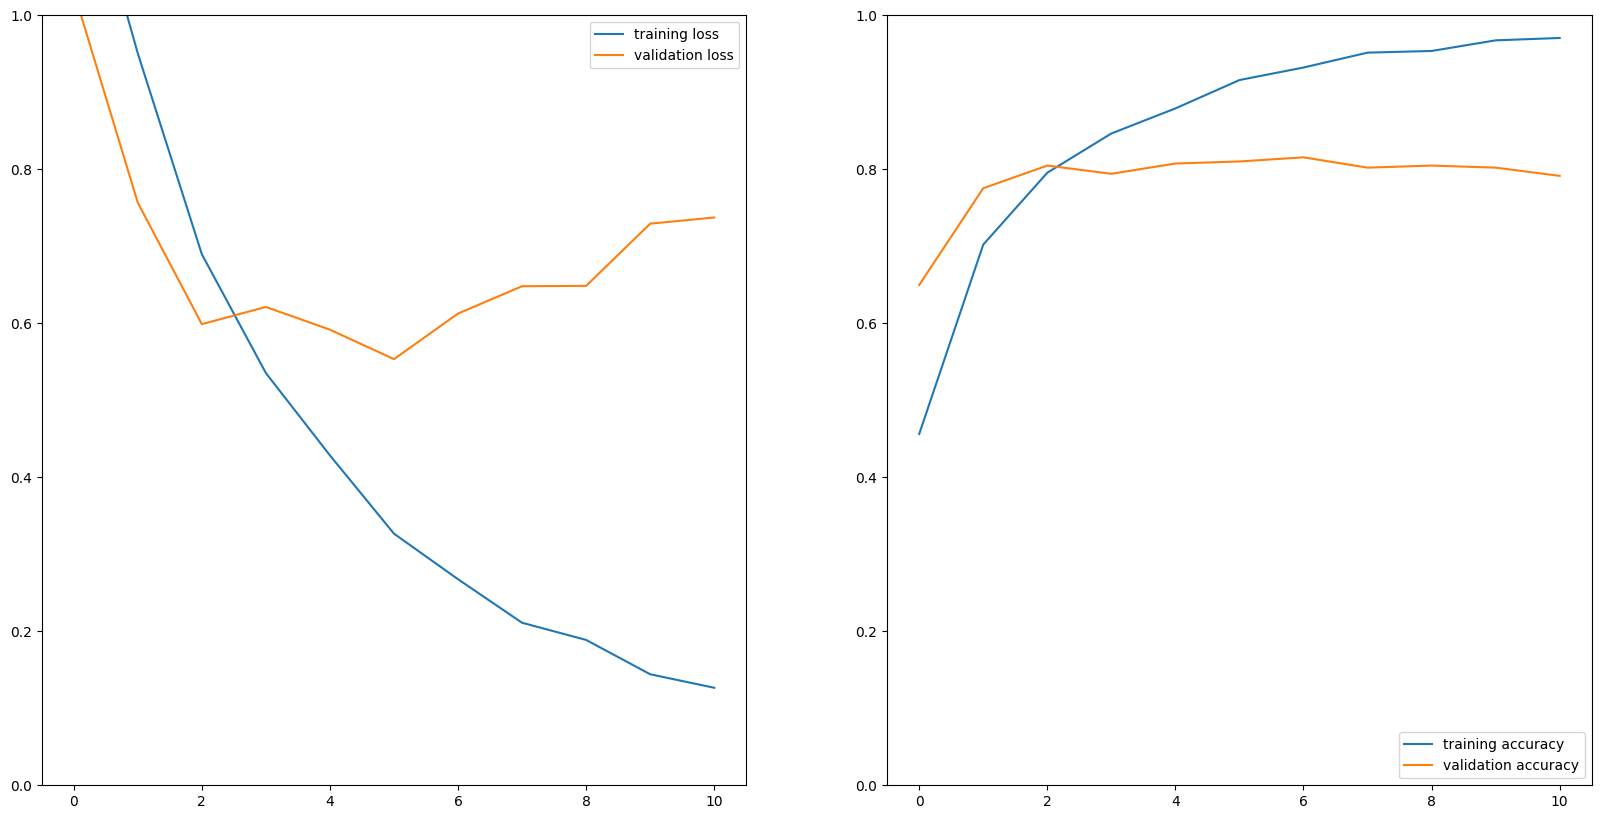

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(best_train_loss, label='training loss')
axs[0].plot(best_val_loss, label='validation loss')
axs[0].legend(loc='upper right')
axs[0].set_ylim(0,1)

axs[1].plot(best_train_acc, label='training accuracy')
axs[1].plot(best_val_acc, label='validation accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylim(0,1)

In [52]:
torch.save(model, "modelloClassificazione.pth")
torch.save(model.state_dict(), "pesiClassificazione.pth")

# Caricamento dataset di Test e calcolo predizioni
Eseguiamo gli stessi passaggi riportati sopra, al fine di ottenere le predizioni sul Test da inviare alla piattaforma


In [53]:
datas = "/content/drive/MyDrive/NLP/Challenge_2024/emotion/test_text.txt"
with open(datas, 'r', encoding='utf-8') as f:
    tweets = f.readlines()

tweets = [tweet.strip() for tweet in tweets]

testdata = pd.DataFrame(tweets, columns=['text'])

testdata

,text
0,#Deppression is real. Partners w/ #depressed p...
1,@user Interesting choice of words... Are you c...
2,My visit to hospital for care triggered #traum...
3,@user Welcome to #MPSVT! We are delighted to h...
4,What makes you feel #joyful?
...,...
1416,I need a sparkling bodysuit . No occasion. Jus...
1417,@user I've finished reading it; simply mind-bl...
1418,shaft abrasions from panties merely shifted to...
1419,All this fake outrage. Y'all need to stop 🤣


In [54]:
testdata['pos_counts'] = testdata['text'].apply(extract_pos_counts)
df_pos = testdata['pos_counts'].apply(pd.Series)
testdata = pd.concat([testdata, df_pos], axis=1)
testdata['word_count'] = testdata['text'].apply(lambda x: len(x.split()))
testdata['important_word_count'] = testdata['JJ'] + testdata['NN'] + testdata['RB'] + testdata['VB']
testdata['text_length'] = testdata['text'].apply(len)
testdata['text'] = testdata['text'].apply(lambda text: emoji.demojize(text))
testdata.drop(["pos_counts", "JJ", "RB"], axis=1, inplace=True)
testdata

,text,VB,NN,word_count,important_word_count,text_length
0,#Deppression is real. Partners w/ #depressed p...,4,7,23,17,144
1,@user Interesting choice of words... Are you c...,2,9,19,14,123
2,My visit to hospital for care triggered #traum...,2,9,24,13,140
3,@user Welcome to #MPSVT! We are delighted to h...,4,5,13,10,86
4,What makes you feel #joyful?,2,1,5,3,28
...,...,...,...,...,...,...
1416,I need a sparkling bodysuit . No occasion. Jus...,2,7,17,10,89
1417,@user I've finished reading it; simply mind-bl...,8,5,20,15,127
1418,shaft abrasions from panties merely shifted to...,1,7,11,9,110
1419,All this fake outrage. Y'all need to stop :rol...,2,2,9,5,43


In [55]:
class TestDataset(torch.utils.data.Dataset):

    def __init__(self, x, VB, NN, word_count, important_word_count, text_length, stopwords):

        tokens_litt = [nltk.word_tokenize(text, language='english')
         for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                    not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))

        self.texts = text_clean
        self.VB = [torch.tensor(vb) for vb in VB]
        self.NN = [torch.tensor(nn) for nn in NN]
        self.word_count = [torch.tensor(word) for word in word_count]
        self.important_word_count = [torch.tensor(impword) for impword in important_word_count]
        self.text_length = [torch.tensor(l) for l in text_length]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_VB = np.array(self.VB[idx])
        batch_NN = np.array(self.NN[idx])
        batch_word_count = np.array(self.word_count[idx])
        batch_important_word_count = np.array(self.important_word_count[idx])
        batch_text_length = np.array(self.text_length[idx])

        return batch_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length

In [56]:
def get_predictions(model, dataloader, tokenizer, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for batch_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            batch_VB = batch_VB.float().to(device)
            batch_NN = batch_NN.float().to(device)
            batch_word_count = batch_word_count.float().to(device)
            batch_important_word_count = batch_important_word_count.float().to(device)
            batch_text_length = batch_text_length.float().to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            output = model(input_id_texts, mask_texts, batch_VB, batch_NN, batch_word_count, batch_important_word_count, batch_text_length).squeeze(1)

            y_pred = output.argmax(dim=1)

            all_preds.extend(y_pred.cpu().numpy())
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            batch_VB = batch_VB.detach().cpu()
            batch_NN = batch_NN.detach().cpu()
            batch_word_count = batch_word_count.detach().cpu()
            batch_important_word_count = batch_important_word_count.detach().cpu()
            batch_text_length = batch_text_length.detach().cpu()
            output = output.detach().cpu()

    return all_preds


In [57]:
x_test = testdata['text']
x_test = x_test.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
VB_test = testdata['VB']
NN_test = testdata['NN']
word_count_test = testdata['word_count']
important_word_count_test = testdata['important_word_count']
text_length_test = testdata['text_length']
test_dataset = TestDataset(x_test, VB_test, NN_test, word_count_test, important_word_count_test, text_length_test, hyperparameters["stopwords"])
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
preds = get_predictions(model, test_dataloader, tokenizer, device)
preds_df = pd.DataFrame(preds, columns=["Prediction"])
preds_df.to_csv("preds.csv", index=False)

dev set: 100%|██████████| 45/45 [00:09<00:00,  4.90it/s]


Nella leaderboard abbiamo ottenuto un punteggio pari a 81.99.
Siamo consapevoli che tramite ulteriori ricerche sulle Features ed eseguendo una Grid-Search più approfondita, si possano ottenere risultati migliori. Inoltre, con un ulteriore potenza di calcolo sarebbe stato possibile utilizzare modelli più larghi e più performanti migliorando maggiormente i risultati.